# Seizure Forecasting using Neural networks

Here use a network of GRU nodes to forecast seizures.

## Import libraries

In [222]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal
import pywt
import datetime as dt
import tensorflow as tf
import keras
import os
from keras.optimizers import Adam, Adadelta
from tensorflow.keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Convolution3D, Reshape, GRU, Permute
from sklearn.metrics import roc_auc_score, roc_curve, r2_score, auc
from sklearn.calibration import calibration_curve
from pandas.plotting import register_matplotlib_converters

## Load the data

Again we load the data.

In [5]:
data = pd.read_csv(r'data/features_day_JE_acausal4.csv')
data

Time  Seizures     IEA_1     IEA_2  CircadianAbs1  \
0    733972.979167         0 -0.688957 -0.824398       1.062300   
1    733973.979167         0 -0.397765 -0.481134       0.925151   
2    733974.979167         2 -0.045270  0.720290       0.647196   
3    733975.979167         0  0.537114  0.319816       0.551267   
4    733976.979167         0 -0.482058 -0.538345       0.767475   
..             ...       ...       ...       ...            ...   
535  734507.979167         1 -0.127745 -0.545234       1.115427   
536  734508.979167         0 -0.576691 -0.545234       0.983173   
537  734509.979167         0 -0.639701 -0.670254       0.988099   
538  734510.979167         0 -0.663330 -0.745266       0.839624   
539  734511.979167         0 -0.222260 -0.395211       0.503807   

     CircadianAngle1  CircadianCos1  CircadianSin1  CircadianFiltSig1  \
0           0.302651       0.954550       0.298052           0.119773   
1           0.052233       0.998636       0.052209          -0.035270   
2          -0.230024       0.973661      -0.228001          -0.022063   
3           0.209761       0.978081       0.208226          -0.025371   
4           0.170185       0.985554       0.169364           0.040485   
..               ...            ...            ...                ...   
535         0.005430       0.999985       0.005430          -0.016796   
536        -0.108773       0.994090      -0.108559          -0.027329   
537        -0.058658       0.998280      -0.058625          -0.019427   
538        -0.020084       0.999798      -0.020082           0.008930   
539        -0.317026       0.950167      -0.311742           0.034325   

     CircadianAbs2  ...  MultidienCos7  MultidienSin7  MultidienFiltSig7  \
0         0.749475  ...       0.744446       0.667682           0.029787   
1         0.830741  ...       0.964069      -0.265653           0.116543   
2         0.192435  ...       0.976613      -0.215003           0.193238   
3         0.098967  ...       0.997251      -0.074096           0.254267   
4         0.422072  ...       0.996082       0.088433           0.295675   
..             ...  ...            ...            ...                ...   
535       1.101473  ...       0.993468       0.114108           0.548256   
536       1.204308  ...       0.939286       0.343135           0.474438   
537       1.241518  ...       0.824040       0.566531           0.363669   
538       1.013170  ...       0.631959       0.775002           0.223788   
539       0.730715  ...       0.301400       0.953498           0.065373   

     MultidienAbs8  MultidienAngle8  MultidienCos8  MultidienSin8  \
0         0.036946        -0.296799       0.956277      -0.292461   
1         0.107939        -0.642337       0.800698      -0.599068   
2         0.167263        -0.532674       0.861452      -0.507839   
3         0.213122        -0.401625       0.920427      -0.390915   
4         0.249645        -0.267405       0.964460      -0.264229   
..             ...              ...            ...            ...   
535       0.366721         0.365830       0.933827       0.357725   
536       0.328287         0.542718       0.856308       0.516465   
537       0.280280         0.734992       0.741836       0.670581   
538       0.219004         0.958782       0.574517       0.818492   
539       0.133596         1.280733       0.286013       0.958226   

     MultidienFiltSig8  meanWeeklySeizures  stdWeeklySeizures  
0             0.013614            0.009809           0.098481  
1             0.074721            0.008465           0.091629  
2             0.132383            0.011279           0.104522  
3             0.184456            0.012681           0.115850  
4             0.229066            0.010870           0.107936  
..                 ...                 ...                ...  
535           0.330746            0.012681           0.115850  
536           0.269407            0.010870           0.107936  
537           

# Plot the different features

## IEA

<IPython.core.display.Javascript object>


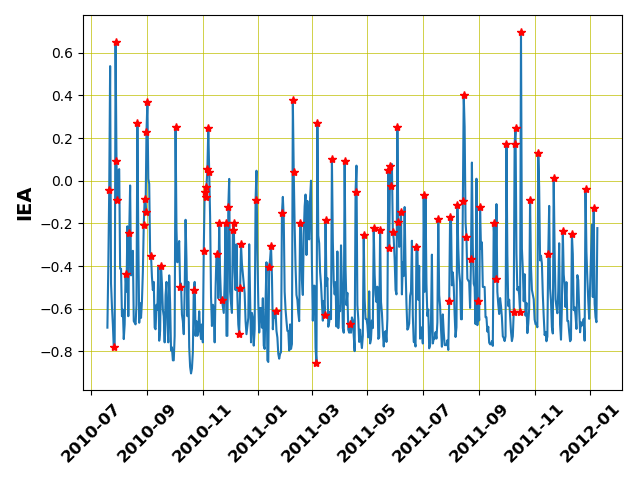

In [42]:
PosSeiz=np.where(data.Seizures>=1)
TimeDate=data.Time[:].astype(int).map(dt.datetime.fromordinal)
register_matplotlib_converters()

plt.figure()
plt.plot(TimeDate,data.IEA_1)
plt.plot(TimeDate.iloc[PosSeiz],data.IEA_1.iloc[PosSeiz],'r*')
plt.ylabel('IEA', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.grid(color = 'y', linewidth='0.5')
plt.tight_layout()
plt.show()

We organize the data such as we take past events for prediction

In [23]:
n_past=50
n_future=1
cosx=[]
sinx=[]
y=[]
CosPhase=data.MultidienCos1.to_numpy()
SinPhase=data.MultidienSin1.to_numpy()
Seiz=data.Seizures.to_numpy()
Seiz[PosSeiz]=1
for i in range(0,len(Seiz)-n_past-n_future+1):
    cosx.append(CosPhase[i : i + n_past])
    sinx.append(SinPhase[i : i + n_past])
    y.append(Seiz[i + n_past : i + n_past + n_future])
cosx = np.array(cosx)
sinx = np.array(sinx)
x = np.stack((cosx,sinx),axis=2)
y = np.array(y)

We select for the train set the minimum between 480 days or 40% of the data.

In [24]:
TestL=min(480,round(x.shape[0]*0.4))    

x_train = x[:TestL,:,:]
y_train = y[:TestL]
x_test = x[TestL:,:,:]
y_test = y[TestL:]

x_train , y_train = np.array(x_train), np.array(y_train)
x_test , y_test = np.array(x_test), np.array(y_test)
print('Shape of training inputs, training target:', x_train.shape, y_train.shape)
print('Shape of test inputs, training target:', x_test.shape, y_test.shape)

Shape of training inputs, training target: (196, 50, 2) (196, 1)
Shape of test inputs, training target: (294, 50, 2) (294, 1)


The data reorganized look like this:

<IPython.core.display.Javascript object>


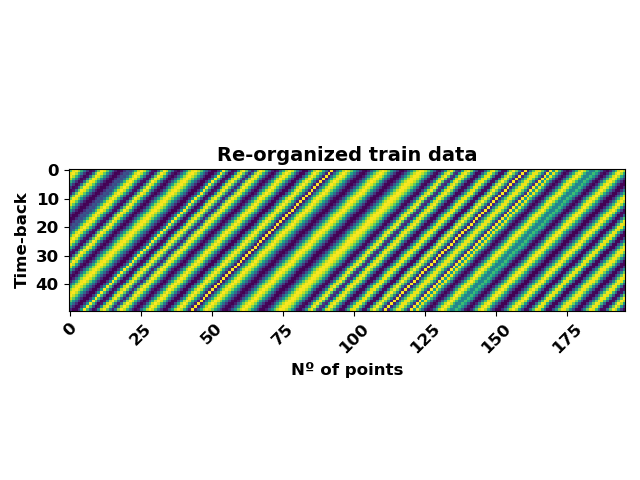

In [22]:
plt.figure()
c=plt.imshow(x_train[:,:,0].T)
plt.title('Re-organized train data',fontsize=14,weight='bold')
plt.ylabel('Time-back',fontsize=12,weight='bold')
plt.xlabel('Nº of points',fontsize=12,weight='bold')
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12, rotation=0)
plt.tight_layout()
plt.show()

### GRU network

We make a neural network with just one GRU layer. We choose sigmoid to have the response from 0 to 1. 

In [33]:
Nodes = 10
input_layer = Input(shape=(x_train.shape[1],2), dtype='float32')
GRUlayer = keras.layers.GRU(Nodes)(input_layer)
dropout_layer = Dropout(0.2)(GRUlayer)
output_layer = Dense(1,activation='sigmoid')(dropout_layer)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="binary_crossentropy",metrics=['accuracy'])
model.summary()



Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50, 2)]           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 10)                420       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 431
Trainable params: 431
Non-trainable params: 0
_________________________________________________________________


### Fit the network 
We choose to have 15% of the data intro the validation set.

In [47]:
history=model.fit(x=x_train, y=y_train,validation_split=0.15, batch_size=50, epochs=50, verbose=0, shuffle=False)
y_pred = model.predict(x_test)
val_loss   = history.history['val_loss']
train_loss = history.history['loss']
print('Model fitted, val loss:', val_loss[49])

Model fitted, val loss: 0.2803555130958557


### Plot the results

In [ ]:
#plot the test vs prediction
PosSeiz=np.where(y_test[:,0]==1)
plt.figure()
plt.plot(y_pred,linestyle='dashed',color='k')
plt.plot(PosSeiz,y_pred[PosSeiz,0],'r*')
plt.legend(['Predicted_SeizRisk','Seizures'], loc='best', prop={'size': 14})
plt.title('Seizure prediction', weight='bold', fontsize=16)
plt.ylabel('Seizure Risk', weight='bold', fontsize=14)
#plt.ylim((0,0.8))
plt.xlabel('Test Set Day no.', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.grid(color = 'y', linewidth='0.5')
plt.show()
#plt.figure()
#plt.xcorr(y_test[:,0], y_pred[:,0], usevlines=True, maxlags=10, normed=True, lw=2)
#plt.grid(True)
#plt.title('Cross-Correlation Y_test vs Y_pred',weight='bold', fontsize=14)
#plt.ylabel('Score', weight='bold', fontsize=14)
#plt.xlabel('Lags', weight='bold', fontsize=14)
#plt.show()
plt.figure()
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred, n_bins=10)
a =plt.hist(y_pred, range=(0, 1), bins=10)
plt.xlabel('Bin')
plt.ylabel('# instances')
Vb=a[0]
Vb=Vb/len(y_pred)
plt.show()
fig, axs = plt.subplots(1, 2)
                    

fpr, tpr, thresholds_keras = roc_curve(y_test, y_pred)
auroc = auc(fpr, tpr)
inseiz=np.where(y_test == 1)
numS=len(inseiz[0])
print('Area under the ROC curve: %.2f' % auroc)
print('Length of the test set: %.0f Nº of seizures: %.0f' %(len(y_test),numS))
axs[0].plot([0, 1], [0, 1], 'k--')
axs[0].plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auroc))
axs[0].legend(['Auroc=0.5','Auroc=%0.2f' %(auroc)])


cl = sum(Vb[:len(fraction_of_positives)]*np.power(fraction_of_positives-mean_predicted_value,2))

axs[1].plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
axs[1].plot(mean_predicted_value, fraction_of_positives, "s-")
axs[1].legend(['Perfectly calibrated', 'Calibration loss=%0.4f' %(cl)])
plt.show()

print(mean_predicted_value)
print(fraction_of_positives)
print(Vb[:len(fraction_of_positives)])

## All subjects together

Get all the files

In [124]:
Files=os.listdir('data')
Files=Files[4:]
Files

['features_day_BJ_acausal4.csv',
 'features_day_DP_acausal4.csv',
 'features_day_EJ_acausal4.csv',
 'features_day_GB_acausal4.csv',
 'features_day_GK_acausal4.csv',
 'features_day_JC_acausal4.csv',
 'features_day_JE_acausal4.csv',
 'features_day_JW_acausal4.csv',
 'features_day_KH_acausal4.csv',
 'features_day_KT_acausal4.csv',
 'features_day_MF_acausal4.csv',
 'features_day_MM_acausal4.csv',
 'features_day_MQ_acausal4.csv',
 'features_day_MR_acausal4.csv',
 'features_day_SS_acausal4.csv',
 'features_day_TC_acausal4.csv',
 'features_day_TV_acausal4.csv',
 'features_day_WP_acausal4.csv']

Take the data from all subjects

In [129]:
import glob
import sys
listsubjects=["BJ","DP","EJ","GB","GK","JC","JE","JW","KH","KT","MF","MM","MQ","MR","SS","TC","TV","WP"]

combined_csv = pd.concat([pd.read_csv(r'data/'+f) for f in Files ],sort=True)
#export to csv
combined_csv

CircadianAbs1  CircadianAbs2  CircadianAngle1  CircadianAngle2  \
0         0.741967       0.195816        -0.157352        -0.797251   
1         0.488426       0.157955        -0.041026         0.347805   
2         0.631091       0.335942         0.079724         0.252257   
3         0.812278       0.223420        -0.233404        -0.240680   
4         0.673431       0.117804         0.084503         0.374781   
..             ...            ...              ...              ...   
936       1.288179       0.580845        -0.011034         0.055533   
937       1.011945       0.506792        -0.079678        -0.049674   
938       1.281974       0.665782         0.035672         0.031197   
939       1.974215       0.931247        -0.016555         0.179755   
940       1.138195       0.487036        -0.519624        -0.319117   

     CircadianCos1  CircadianCos2  CircadianFiltSig1  CircadianFiltSig2  \
0         0.987646       0.698676           0.212183           0.022223   
1         0.999159       0.940123          -0.004602           0.021030   
2         0.996824       0.968352           0.025310           0.016220   
3         0.972885       0.971176           0.062200           0.005164   
4         0.996432       0.930588          -0.043102           0.038781   
..             ...            ...                ...                ...   
936       0.999939       0.998458           0.038901           0.013081   
937       0.996827       0.998767          -0.007889          -0.018497   
938       0.999364       0.999513          -0.021309          -0.032290   
939       0.999863       0.983887           0.064215           0.052693   
940       0.868006       0.949513          -0.010031           0.005111   

     CircadianSin1  CircadianSin2  ...  MultidienSin3  MultidienSin4  \
0        -0.156703      -0.715438  ...      -0.995160      -0.998556   
1        -0.041014       0.340835  ...      -0.951817      -0.983058   
2         0.079639       0.249590  ...      -0.865737      -0.952528   
3        -0.231290      -0.238363  ...      -0.740759      -0.908848   
4         0.084402       0.366068  ...      -0.582238      -0.853634   
..             ...            ...  ...            ...            ...   
936      -0.011034       0.055504  ...       0.460107      -0.881568   
937      -0.079594      -0.049653  ...       0.627937      -0.516003   
938       0.035665       0.031192  ...       0.778071       0.003703   
939      -0.016554       0.178789  ...       0.902112       0.545416   
940      -0.496554      -0.313728  ...       0.985802       0.937537   

     MultidienSin5  MultidienSin6  MultidienSin7  MultidienSin8  Seizures  \
0        -0.989955      -0.998140      -0.999990            NaN         0   
1        -0.852901      -0.972647      -0.999700            NaN         0   
2        -0.498544      -0.904112      -0.998859            NaN         1   
3         0.136849      -0.781928      -0.997459            NaN         0   
4         0.999997      -0.599013      -0.995773            NaN         0   
..             ...            ...            ...            ...       ...   
936      -0.183579       0.456713            NaN            NaN         0   
937       0.119061       0.628940            NaN            NaN         0   
938       0.427690       0.781720            NaN            NaN         0   
939       0.716925       0.906127            NaN            NaN         1   
940       0.949100       0.987638            NaN            NaN         0   

              Time  meanWeeklySeizures  stdWeeklySeizures  
0    737181.979167            0.008418           0.091440  
1    737182.979167            0.006667           0.080787  
2    737183.979167            0.006752           0.081246  
3    737184.979167            0.008592           0.092372  
4    737185.979167            0.007812           0.087980  
..             ...                 ...                ...  
936  736856.104167            0.050680   

Organize the data for each subject

In [191]:
StartSubj=np.where(combined_csv.index == 0)
StartSubj=StartSubj[0]
print(StartSubj)
NewStart=np.zeros(len(StartSubj)-1,dtype=int)
cosx=[]
sinx=[]
cosxx=[]
y=[]
n_past=50
n_future=1
for j in range(len(StartSubj)-1):
    CosPhase=combined_csv.MultidienCos1[StartSubj[j]:StartSubj[j+1]].to_numpy()
    SinPhase=combined_csv.MultidienSin1.iloc[StartSubj[j]:StartSubj[j+1]].to_numpy()
    Seiz=combined_csv.Seizures.iloc[StartSubj[j]:StartSubj[j+1]].to_numpy()
    PosSeiz=np.where(Seiz>=1)
    Seiz[PosSeiz]=1
    for i in range(0,len(Seiz)-n_past-n_future+1):
        cosx.append(CosPhase[i : i + n_past])
        sinx.append(SinPhase[i : i + n_past])
        y.append(Seiz[i + n_past : i + n_past + n_future])
    NewStart[j]=len(cosx)
    
cosx = np.array(cosx)
sinx = np.array(sinx)
x = np.stack((cosx,sinx),axis=2)
y = np.array(y)
NewStart

[   0  285  671 1111 1415 2286 2724 3264 3629 3856 4346 4792 5841 6525
 6899 7188 7639 8052]


array([ 235,  571,  961, 1215, 2036, 2424, 2914, 3229, 3406, 3846, 4242,
       5241, 5875, 6199, 6438, 6839, 7202])

### We train subjects and test on new ones

First we make same model again

In [192]:
Nodes = 10
keras.backend.clear_session()

input_layer = Input(shape=(x.shape[1],2), dtype='float32')
GRUlayer = keras.layers.GRU(Nodes)(input_layer)
dropout_layer = Dropout(0.2)(GRUlayer)
output_layer = Dense(1,activation='sigmoid')(dropout_layer)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="binary_crossentropy",metrics=['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 2)]           0         
_________________________________________________________________
gru (GRU)                    (None, 10)                420       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 431
Trainable params: 431
Non-trainable params: 0
_________________________________________________________________


We fit the model with only a percentatge of the subjects

In [196]:
NsubjTrain=10
history=model.fit(x=x[:NewStart[NsubjTrain],:,:], y=y[:NewStart[NsubjTrain]],validation_split=0.15, batch_size=200, epochs=50, verbose=0, shuffle=False)
y_pred = model.predict(x_test)
val_loss   = history.history['val_loss']
train_loss = history.history['loss']
print('Model fitted, val loss:', val_loss[49])

Model fitted, val loss: 0.6030393838882446


Plot validation curve

<IPython.core.display.Javascript object>


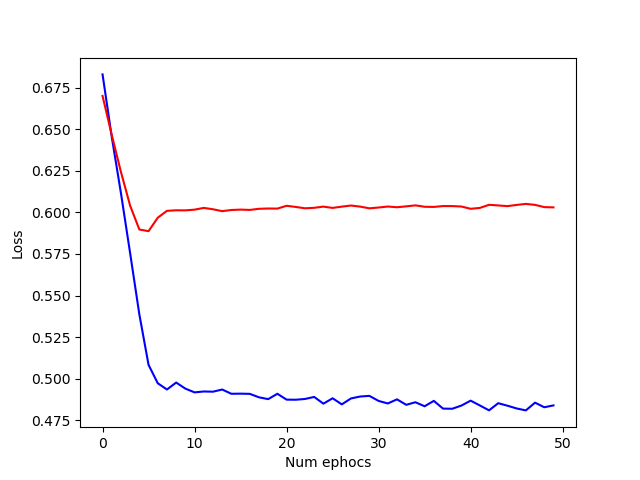

In [199]:
plt.figure()
plt.plot(train_loss,'b-')
plt.plot(val_loss,'r-')
plt.xlabel('Num ephocs')
plt.ylabel('Loss')
plt.show()

### Predict with new subjects

Here we use subjects we did not use to test model

In [218]:
y_pred=model.predict(x[NewStart[NsubjTrain]:,:,:])
y_pred.shape
y_test=y[NewStart[NsubjTrain]:]
StartTest=np.cumsum((np.ediff1d(NewStart[NsubjTrain:])))
StartTest
StartTest=np.insert(StartTest, 0, 0, axis=0)
StartTest

array([   0,  999, 1633, 1957, 2196, 2597, 2960], dtype=int32)

### Plot ROC curve for the test

<IPython.core.display.Javascript object>


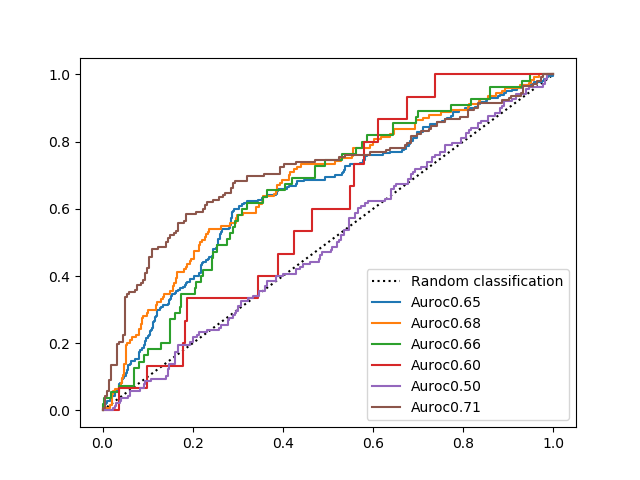

In [226]:
plt.figure()
plt.plot([0, 1], [0, 1], "k:", label="Random classification")
for i in range(len(StartTest)-1):
    fpr, tpr, thresholds_keras = roc_curve(y_test[StartTest[i]:StartTest[i+1]], y_pred[StartTest[i]:StartTest[i+1]])
    auroc=auc(fpr,tpr)
    plt.plot(fpr,tpr,label='Auroc%0.2f' %auroc)
plt.legend()    
plt.show()